In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


### Part 1

In [206]:
class AdvData:
    def __init__(self, filepath):
        df = pd.read_csv(filepath)
        self.u = df['U']
        self.t = df['time']
        self.u_filtered_gn = self.u.copy()

    def makeHistogram(self):
        plt.xlabel("Velocity")
        plt.ylabel("Counts")
        plt.title("Velocity Histogram")
        plt.hist(self.u)
        plt.show()
        return

    def makeTimeSeriesPlot(self):
        plt.xlabel("Time")
        plt.ylabel("Velocity")
        plt.title("Time Series Plot")
        plt.plot(self.t,self.u)
        plt.show()
        return
    
    def applyThreshold(self, threshold):
        """
        Applies a threshold to self.u, setting values below the threshold to np.nan.
        Creates a filtered array, self.u_filtered, and calculates the percentage of NaN values.
        """
        self.u_filtered = self.u.copy()
        self.u_filtered[self.u_filtered > threshold] = np.nan
        nan_percentage = np.isnan(self.u_filtered).mean() * 100
        print(f"Percentage of data set to NaN: {nan_percentage:.2f}%")
        
        return nan_percentage

    def isBad(self,x,xbar,y,ybar,a,b,t):
        num1 = (np.cos(t)*(x-xbar)+np.sin(t)*(y-ybar))**2
        num2 = (np.sin(t)*(x-xbar)+np.cos(t)*(y-ybar))**2
        val = num1/(a**2) + num2/(b**2)           # print(val)
        return val>1
            
    def makeEllipses(self,a, b, ax, theta=None):
        t = np.linspace(0, 2 * np.pi, 1000)
        ellipse_x = a * np.cos(t)
        ellipse_y = b * np.sin(t)
        if theta:
            # Apply rotation by theta
            rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])                
            rotated_points = np.dot(rotation_matrix, np.array([ellipse_x, ellipse_y]))
            ellipse_x, ellipse_y = rotated_points[0], rotated_points[1]
        ax.plot(ellipse_x,ellipse_y)

    #Part2
    def goringNikora(self):
        bad_indices = []
        it = 1
        while True:
            #1 
            d1 = np.gradient(self.u_filtered_gn)
            d2 = np.gradient(d1)
            #2
            sdv = self.u_filtered_gn.std()
            sd1 = d1.std()
            sd2 = d2.std()

            #3
            lamb = (2 * np.log(len(self.u_filtered_gn))) ** 0.5

            #4
            t_num = np.sum(self.u_filtered_gn * d2)
            t_denom = np.sum(self.u_filtered_gn ** 2)
            theta = np.arctan(t_num / t_denom) if t_denom != 0 else 0

            #5
            a1 = lamb * sdv
            b1 = lamb * sd1
            matrix = [[np.cos(theta) ** 2, np.sin(theta) ** 2],
                  [np.sin(theta) ** 2, np.cos(theta) ** 2]]
            sol = [a1 ** 2, (lamb * sd2) ** 2]
            a_val, b_val = np.linalg.solve(matrix, sol)
            a2 = np.sqrt(a_val)
            b2 = np.sqrt(b_val)
            a3 = lamb * sd1
            b3 = lamb * sd2

            #6
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

            self.makeEllipses(a1, b1, ax1, 0)
            print(f"Iteration {it} theta = {theta}") 
            self.makeEllipses(a2, b2, ax2, theta)
            self.makeEllipses(a3, b3, ax3, 0)

            ax1.plot(self.u_filtered_gn, d1, 'o', alpha=0.7)
            ax2.plot(self.u_filtered_gn, d2, 'o', alpha=0.7)
            ax3.plot(d1, d2, 'o', alpha=0.7)

            #7
            bad_indices = []
            for i in range(len(self.u_filtered_gn)):
                t1 = self.isBad(self.u_filtered_gn[i], self.u_filtered_gn.mean(), d1[i], d1.mean(), a1, b1, 0)
                t2 = self.isBad(self.u_filtered_gn[i], self.u_filtered_gn.mean(), d2[i], d2.mean(), a2, b2, theta)
                t3 = self.isBad(d1[i], d1.mean(), d2[i], d2.mean(), a3, b3, 0)
                if t1 or t2 or t3:
                    bad_indices.append(i)

            print(f"Number of bad indices: {len(bad_indices)}")

            #8
            self.u_filtered_gn.iloc[bad_indices] = np.nan
            self.u_filtered_gn = self.u_filtered_gn.interpolate(method="nearest")

            plt.show()
            it+=1

            if len(bad_indices) <= 5:
                break

        return len(bad_indices)
        
    def endQuestions(self):
        fig, ax = plt.subplots()
        ax.plot(self.t, self.u,label= "original",alpha = .6)
        ax.plot(self.t, self.u_filtered_gn,label = "filtered")
        plt.xlabel("Time")
        plt.ylabel("Velocity")
        plt.legend()
        plt.show()
        

In [210]:
a21 = AdvData("adv.csv")

Iteration 1 theta = -0.3286391920655126
Number of bad indices: 355


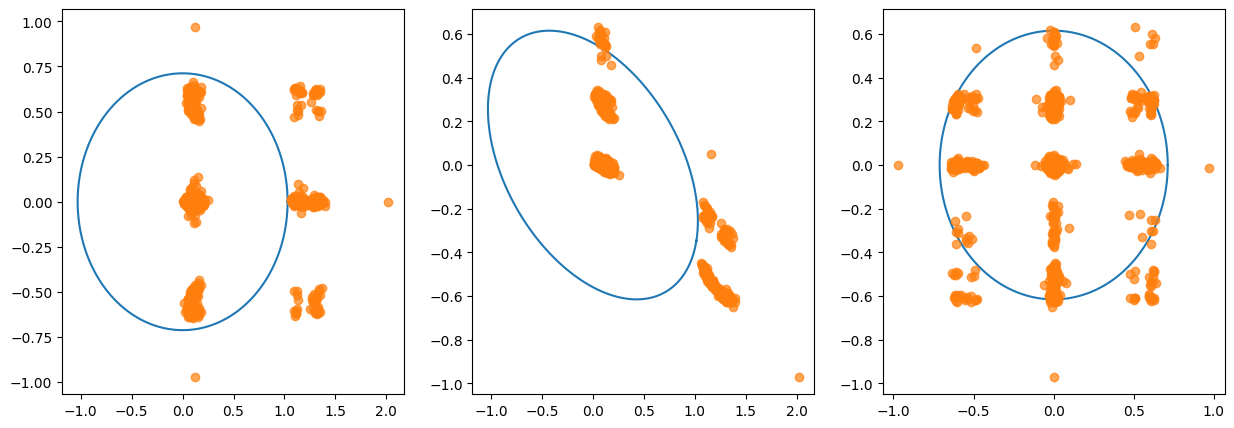

Iteration 2 theta = -0.012068009667835467
Number of bad indices: 0


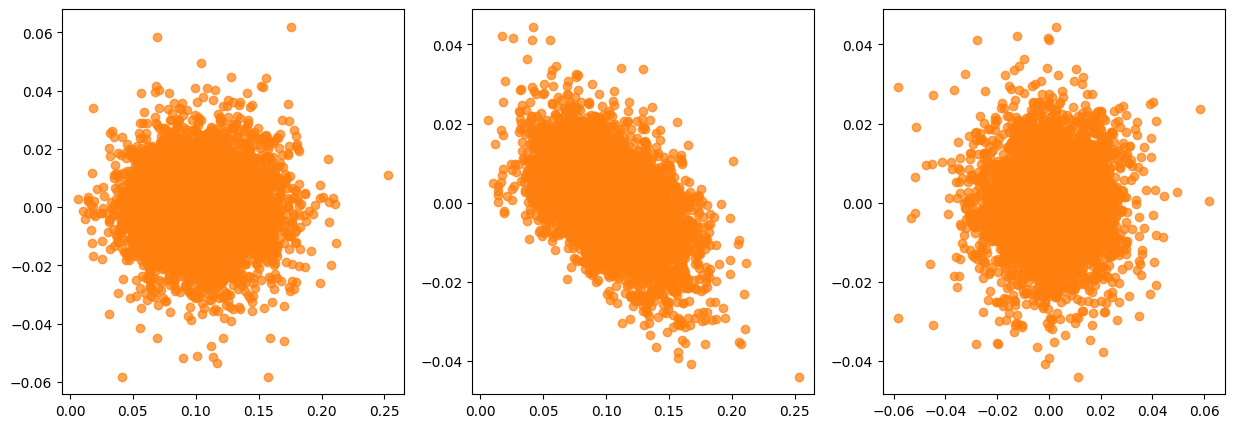

In [211]:
s = a21.goringNikora()
#print(s)


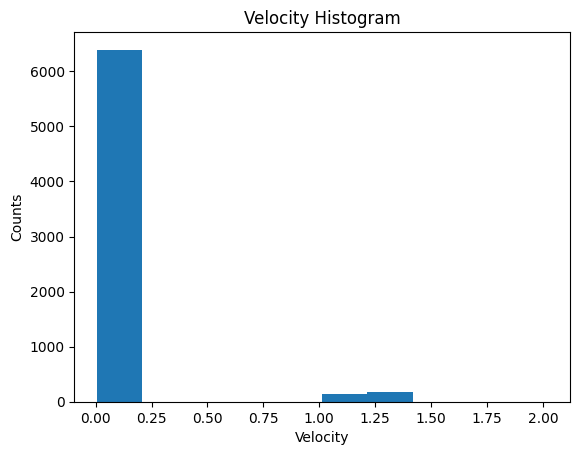

In [213]:
a21.makeHistogram()

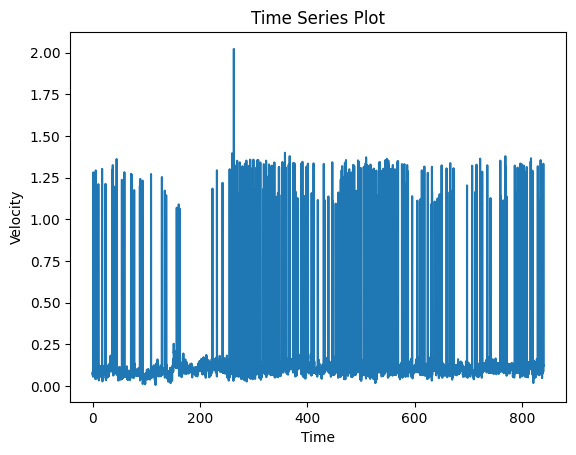

In [214]:
a21.makeTimeSeriesPlot()

It is hard to distinguish from noise when viewing these plots. The upper outliers for the histogram particularly skew the scale of the distribution, and the time series plot is hard to read

In [216]:
a21.applyThreshold(threshold = .5)

Percentage of data set to NaN: 4.82%


4.821428571428572

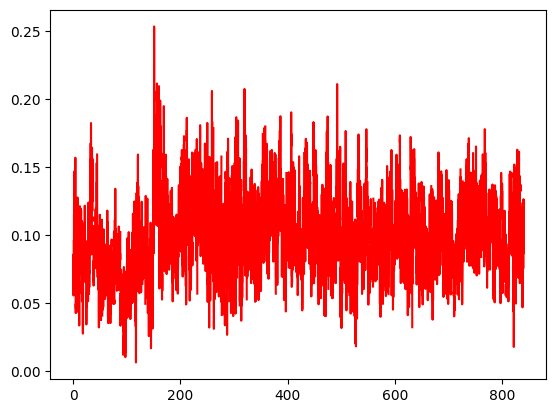

In [217]:
plt.plot(a21.t, a21.u_filtered, color = "red", label = "filtered")

## 1.4

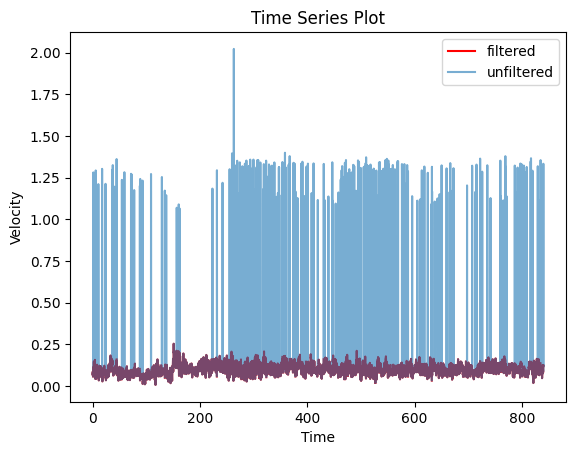

In [219]:
plt.xlabel("Time")       
plt.ylabel("Velocity")
plt.title("Time Series Plot")
plt.plot(a21.t, a21.u_filtered, color = "red", label = "filtered", )
plt.plot(a21.t,a21.u, label = "unfiltered", alpha = .6)
plt.legend()



The threshhold applied seems effective in reducing the confusion from the noise on the graph. There is a much more reasonable distribution of data and we arent thrown off by the few occurences that cause the graph to spike which provides a misleading view of the data(the spikes only caused by very small % of high u values, but hard to tell that from plot originally)

## End of assignment questions

It took my algorithm 2 iterations to converge using nearest neighbor interpolation

The end result looks very similar when contrasted with the filtering done in part1, both in its behavior and magnitude 

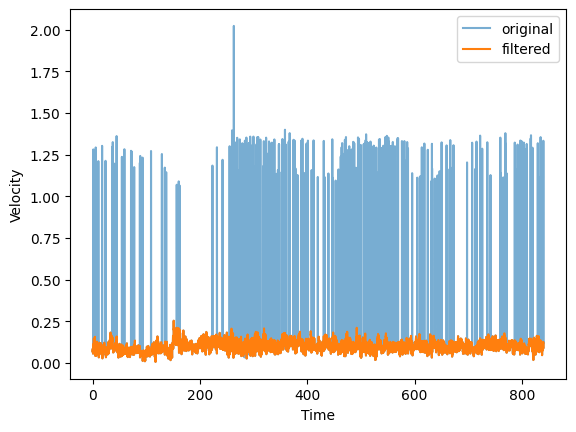

In [224]:
a21.endQuestions()